In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


In [2]:
# ==================================================================
# IMPORT LIBRARIES
# =================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from IPython.display import display #To display dataframe with a nice format.

# Setting display precision for pandas
pd.set_option("display.precision", 2)
# Set display option to show all columns
pd.set_option('display.max_columns', None)

blue_green      = (82/255, 162/255, 160/255)
blue_green_dark = (41/255, 81/255, 81/255)

# ==================================================================================================
# Set the fontsize & Bold for each GRAPH !!!
# ==================================================================================================
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["lines.markersize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['axes.titlepad'] = 20 

In [3]:
# ==================================================================
# LOAD DATASET
# =================================================================
df = pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv',sep='\t')
display(df.head(3))

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0


In [4]:
# ==================================================================
# EXPLANATION OF THE FEATURES
# =================================================================
# Source : Dataset 

| **Feature**             | **Description**                                          |
|-------------------------|----------------------------------------------------------|
| ID                      | Customer's unique identifier                             |
| Year_Birth              | Customer's birth year                                    |
| Education               | Customer's education level                               |
| Marital_Status          | Customer's marital status                                |
| Income                  | Customer's yearly household income                       |
| Kidhome                 | Number of children in customer's household               |
| Teenhome                | Number of teenagers in customer's household              |
| Dt_Customer             | Date of customer's enrollment with the company           |
| Recency                 | Number of days since customer's last purchase            |
| Complain                | 1 if the customer complained in the last 2 years, 0 otherwise |
| MntWines                | Amount spent on wine in last 2 years                     |
| MntFruits               | Amount spent on fruits in last 2 years                   |
| MntMeatProducts         | Amount spent on meat in last 2 years                     |
| MntFishProducts         | Amount spent on fish in last 2 years                     |
| MntSweetProducts        | Amount spent on sweets in last 2 years                   |
| MntGoldProds            | Amount spent on gold in last 2 years                     |
| NumDealsPurchases       | Number of purchases made with a discount                 |
| AcceptedCmp1            | 1 if customer accepted the offer in the 1st campaign, 0 otherwise |
| AcceptedCmp2            | 1 if customer accepted the offer in the 2nd campaign, 0 otherwise |
| AcceptedCmp3            | 1 if customer accepted the offer in the 3rd campaign, 0 otherwise |
| AcceptedCmp4            | 1 if customer accepted the offer in the 4th campaign, 0 otherwise |
| AcceptedCmp5            | 1 if customer accepted the offer in the 5th campaign, 0 otherwise |
| Response                | 1 if customer accepted the offer in the last campaign, 0 otherwise |
| NumWebPurchases         | Number of purchases made through the company’s website   |
| NumCatalogPurchases     | Number of purchases made using a catalogue               |
| NumStorePurchases       | Number of purchases made directly in stores              |
| NumWebVisitsMonth       | Number of visits to company’s website in the last month  |

In [5]:
# ==================================================================
# EXPLORE THE DATA
# =================================================================

In [6]:
# Find the top 10 most correlated numerical feature pairs, excluding the diagonal
def get_top_correlated_pairs(correlation_matrix, n=10):
    # Set the diagonal values to NaN to exclude self-correlations
    corr_matrix_no_diag = correlation_matrix.where(~np.eye(correlation_matrix.shape[0], dtype=bool))
    
    # Unstack the correlation matrix, sort the pairs by correlation value, and get the top n pairs
    top_corr_pairs = corr_matrix_no_diag.unstack().sort_values(kind="quicksort", ascending=False).dropna().head(n)
    
    return top_corr_pairs

# Function to calculate the outliers using the IQR method
def calculate_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

def perform_eda(df):
    """
    Performs an enhanced exploratory data analysis on the given DataFrame.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame to analyze.
    """
    # Display the shape of the dataset
    display("Dataset Shape:", df.shape)
    
    # Display data types and non-null counts
    print("\nData Types and Non-Null Counts:")
    display(df.info())
    
    # Numerical and categorical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Calculate skewness and kurtosis and display them in a DataFrame
    skewness_kurtosis_df = pd.DataFrame({
        'Skewness': df[num_cols].skew(),
        'Kurtosis': df[num_cols].kurtosis()
    })

    # Display skewness and kurtosis in a combined DataFrame
    print("\nSkewness and Kurtosis:")
    display(skewness_kurtosis_df)
    
    # Check for missing values
    display("\nMissing Values:")
    display(df.isnull().sum())
    
    # Plot missing values heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()
    
    # Plot distributions and boxplots of numerical features in a single figure with subplots
    for col in num_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 grid of subplots

        # Distribution plot (histogram with KDE)
        sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title(f'Distribution of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Boxplot for outlier detection
        sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
        axes[1].set_title(f'Boxplot of {col}')
        axes[1].set_xlabel(col)

        plt.tight_layout()  # Adjust the layout to prevent overlapping elements
        plt.show()

        # Calculate and display the number of outliers
        outliers = calculate_outliers(df, col)
        num_outliers = len(outliers)
        print(f'Number of outliers in {col}: {num_outliers}')
    
    # Plot counts of categorical features
    for col in cat_cols:
        plt.figure(figsize=(10, 4))
        sns.countplot(y=df[col], order=df[col].value_counts().index, palette='viridis')
        plt.title(f'Count of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.show()
        
    
    # Plot correlation matrix for numerical features
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[num_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
    plt.title('Correlation Matrix')
    plt.show()
    
    
    # Additional analysis
    display("\nAdditional Analysis:")
    
    # Find the top 10 most correlated numerical feature pairs
    top_corr_pairs = get_top_correlated_pairs(correlation_matrix, n=10)
    print("Top 10 Most Correlated Feature Pairs:")
    display(top_corr_pairs)
    
    # Check for any duplicate rows
    num_duplicates = df.duplicated().sum()
    display(f"\nNumber of Duplicate Rows: {num_duplicates}")

    return df

'Dataset Shape:'

(2240, 29)


Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDe

None


Skewness and Kurtosis:


,Skewness,Kurtosis
ID,3.98e-02,-1.19
Year_Birth,-3.50e-01,0.72
Income,6.76e+00,159.64
Kidhome,6.35e-01,-0.78
Teenhome,4.07e-01,-0.99
Recency,-1.99e-03,-1.20
MntWines,1.18e+00,0.60
MntFruits,2.10e+00,4.05
MntMeatProducts,2.08e+00,5.52
MntFishProducts,1.92e+00,3.10


'\nMissing Values:'

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

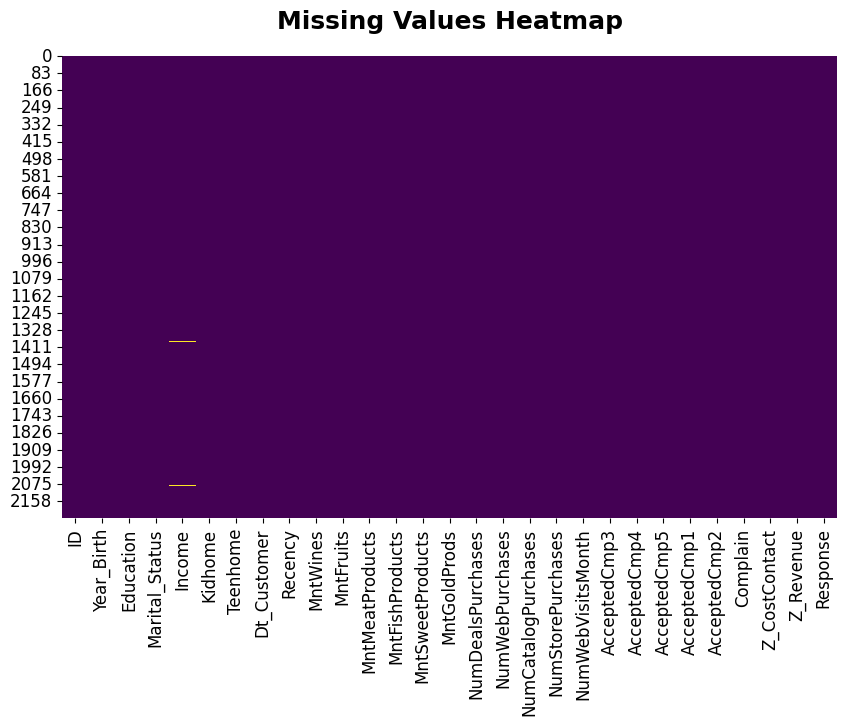

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


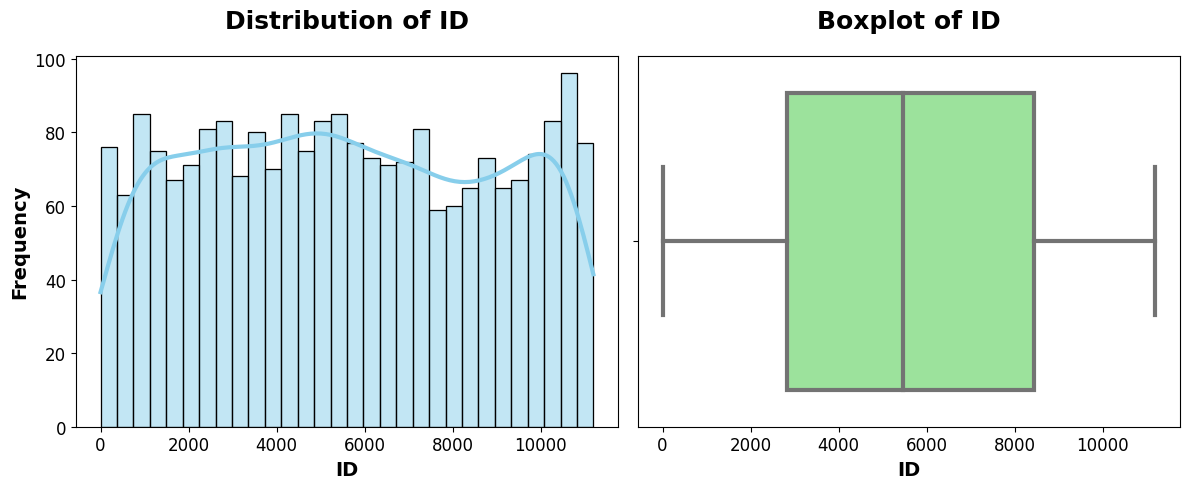

Number of outliers in ID: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


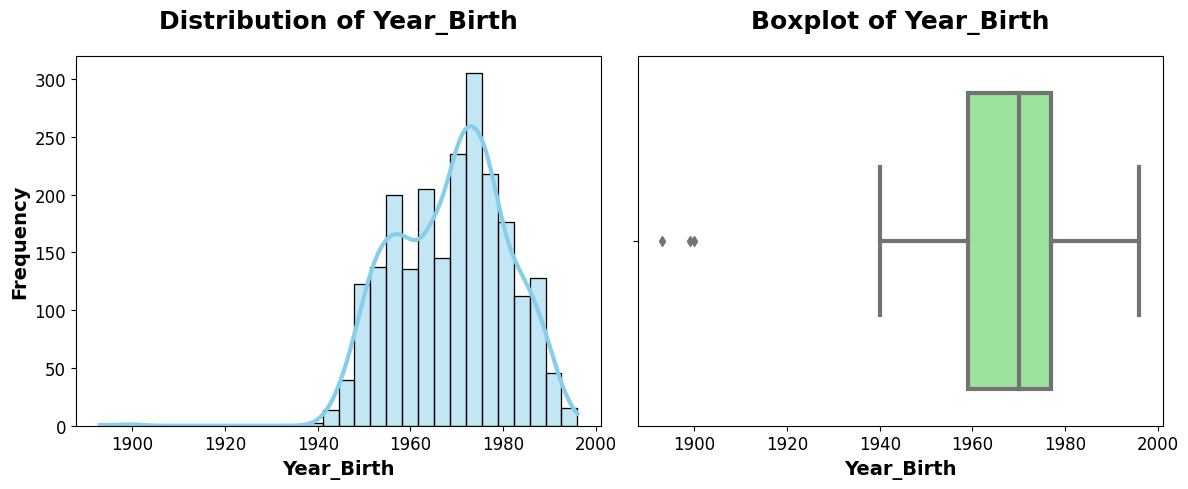

Number of outliers in Year_Birth: 3


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


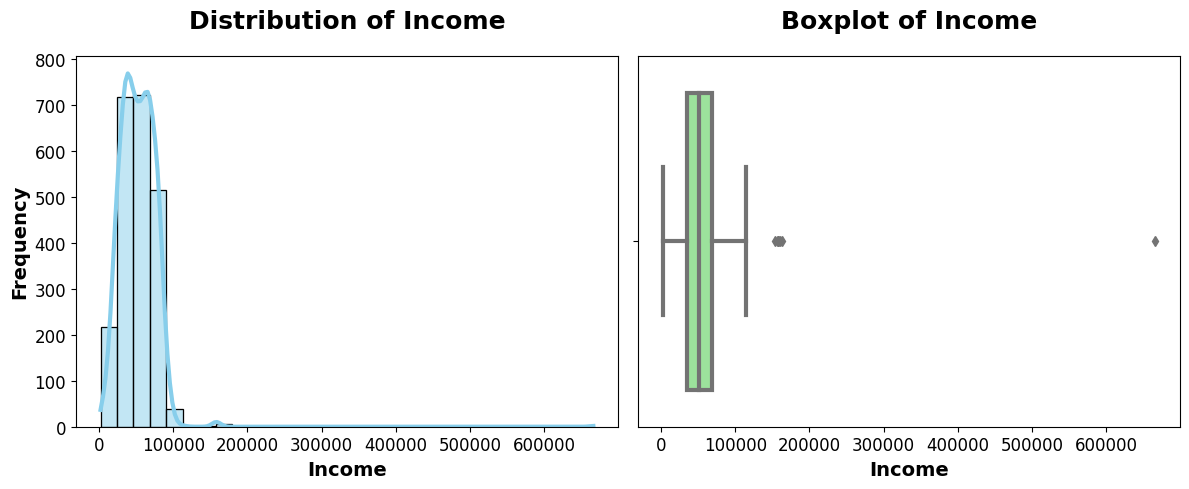

Number of outliers in Income: 8


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


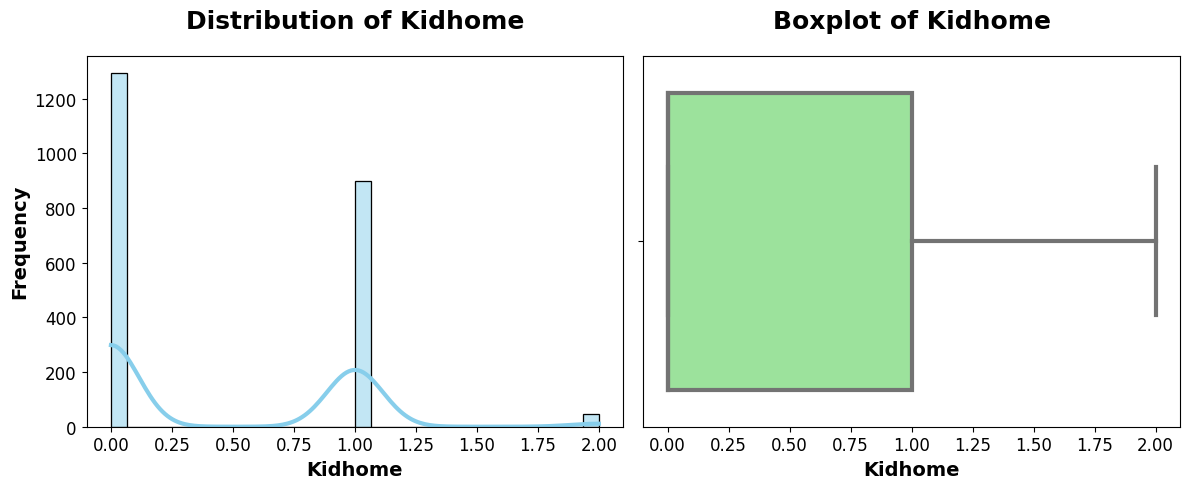

Number of outliers in Kidhome: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


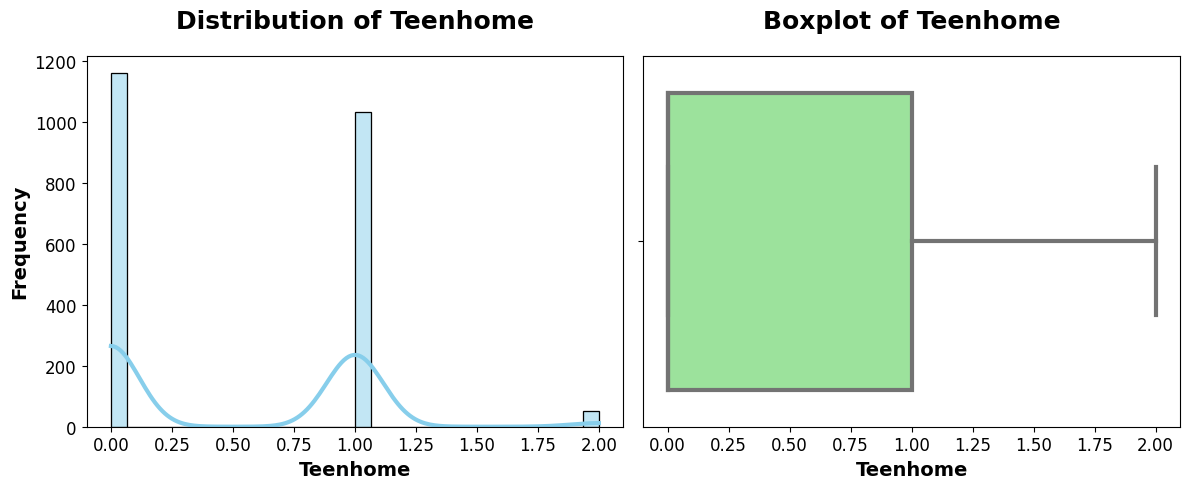

Number of outliers in Teenhome: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


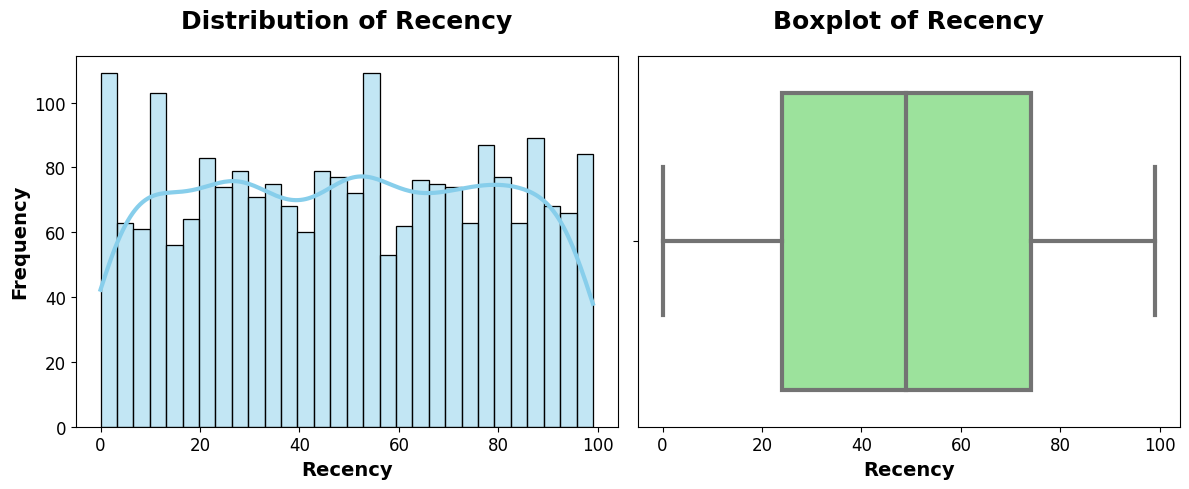

Number of outliers in Recency: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


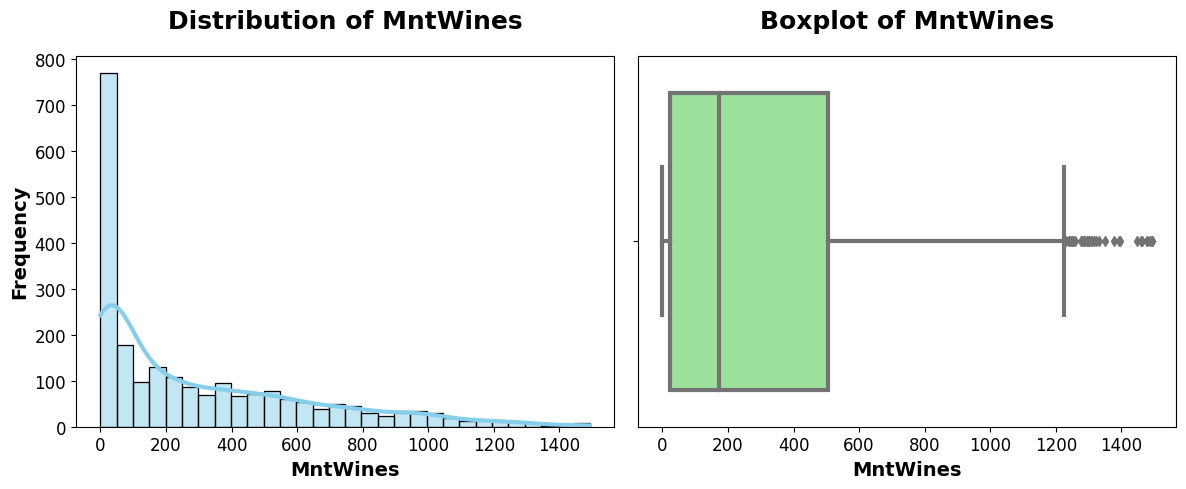

Number of outliers in MntWines: 35


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


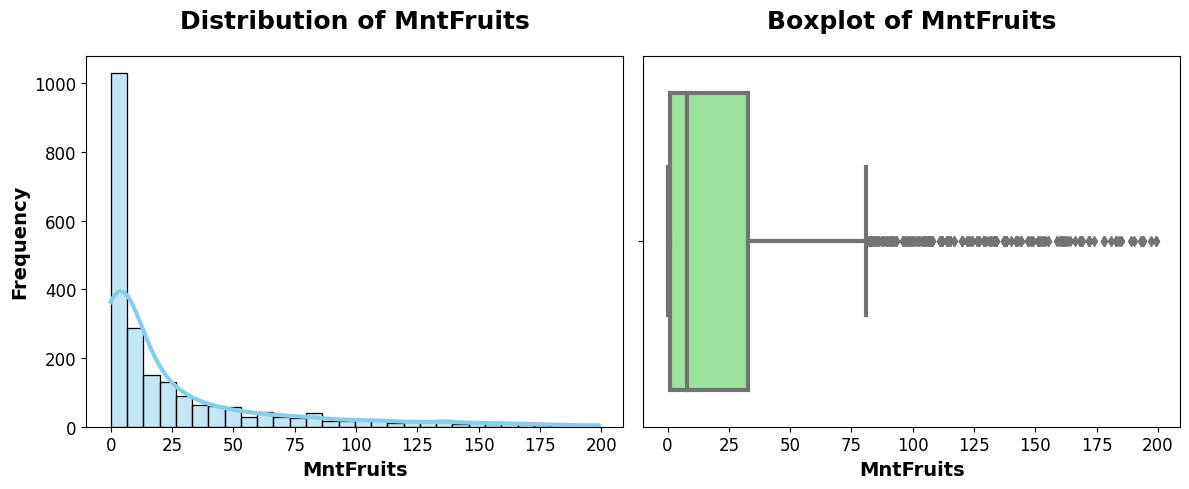

Number of outliers in MntFruits: 227


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


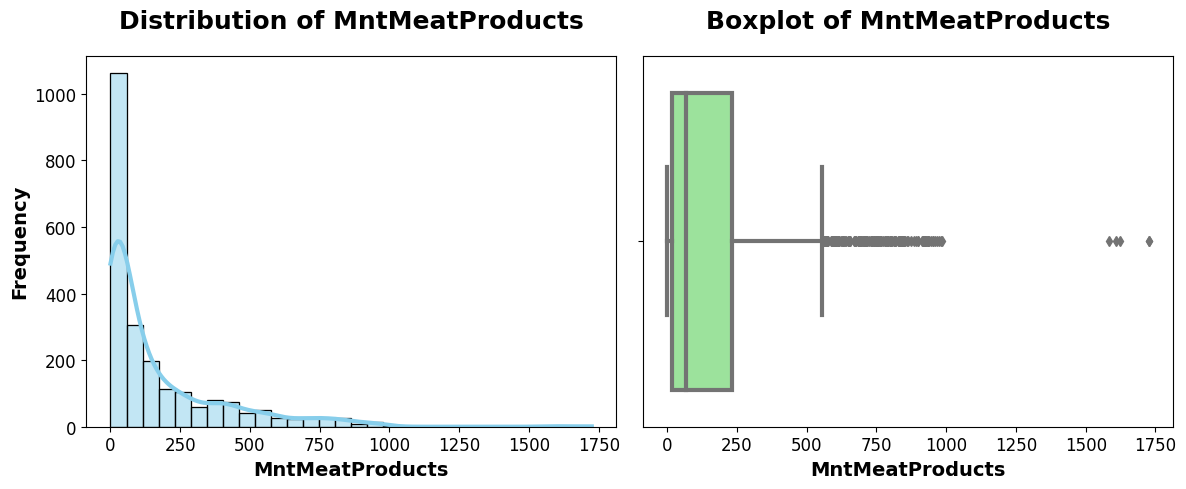

Number of outliers in MntMeatProducts: 175


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


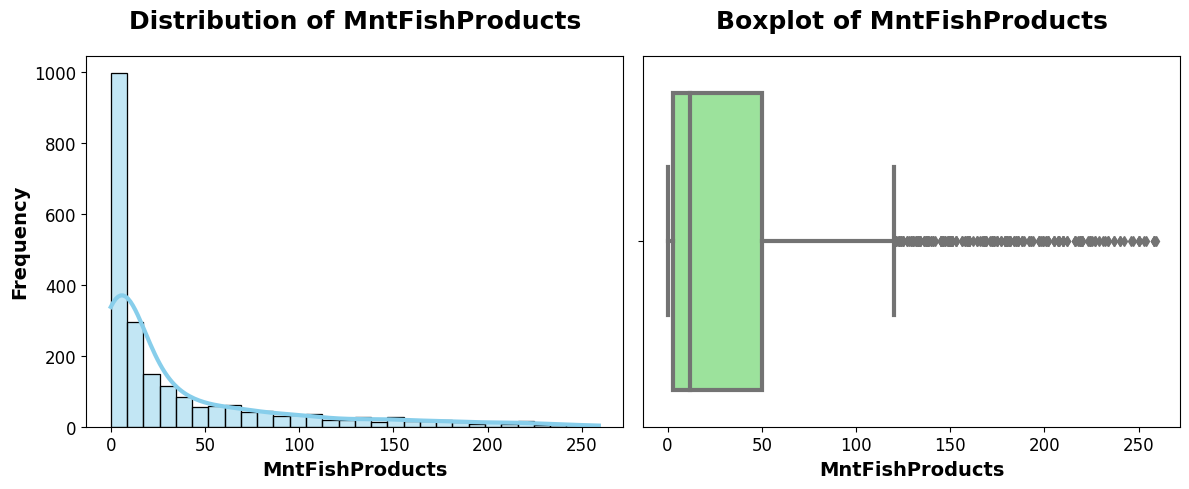

Number of outliers in MntFishProducts: 223


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


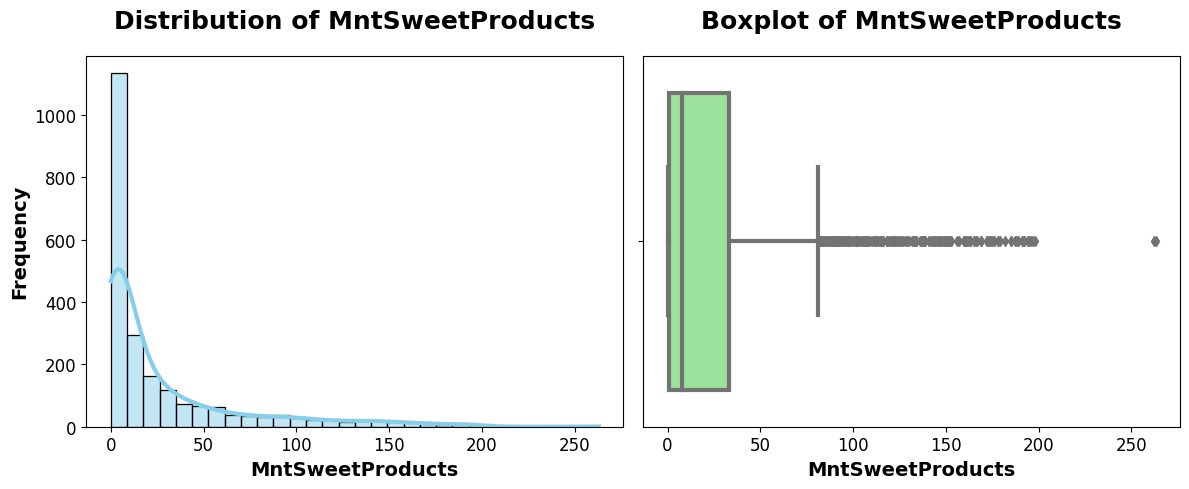

Number of outliers in MntSweetProducts: 248


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


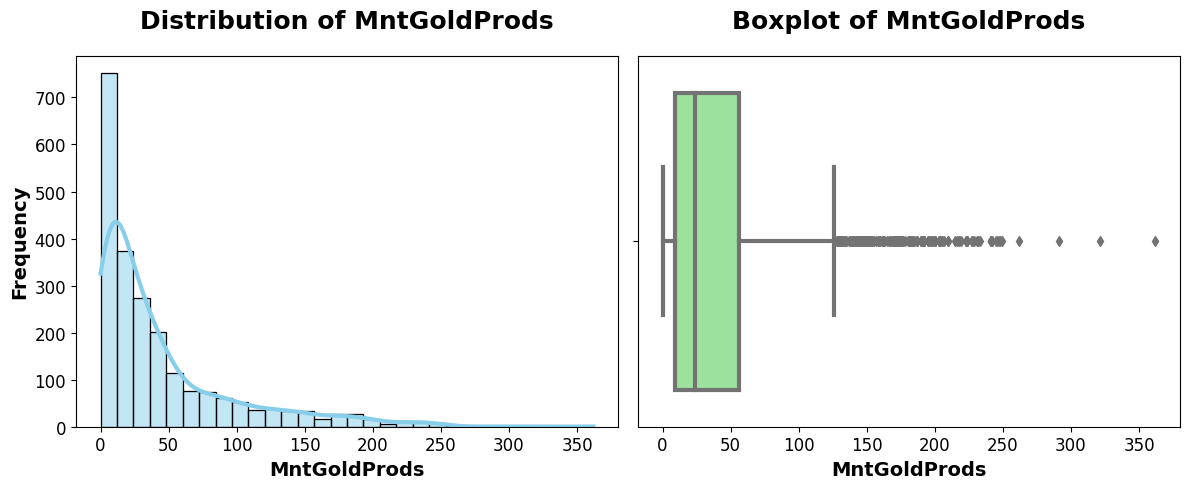

Number of outliers in MntGoldProds: 207


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


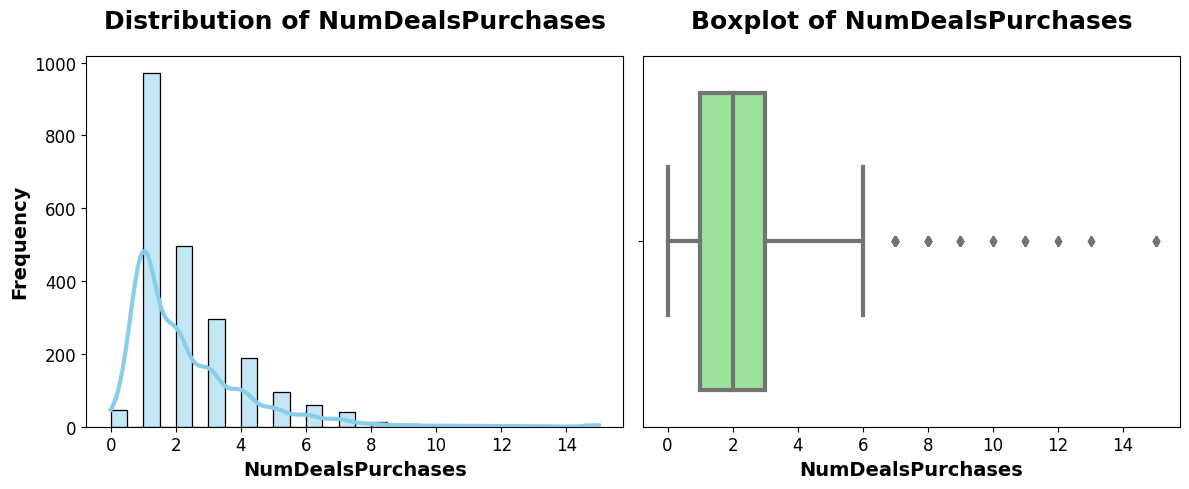

Number of outliers in NumDealsPurchases: 86


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


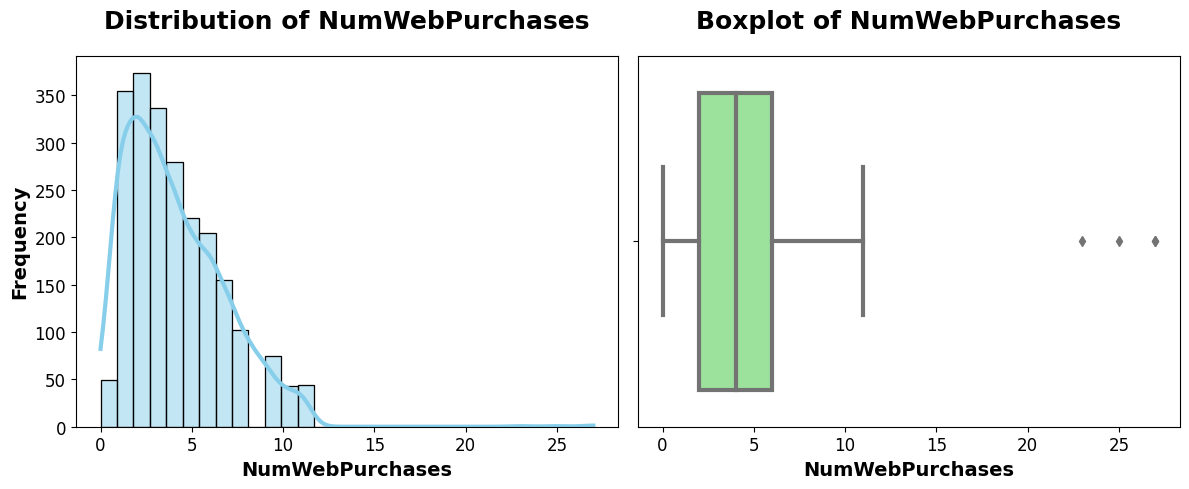

Number of outliers in NumWebPurchases: 4


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


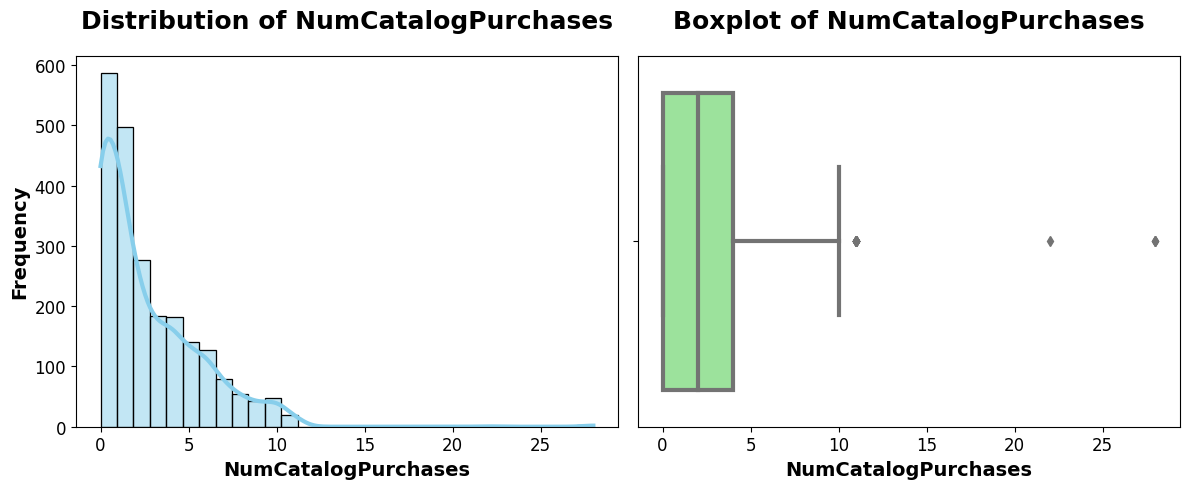

Number of outliers in NumCatalogPurchases: 23


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


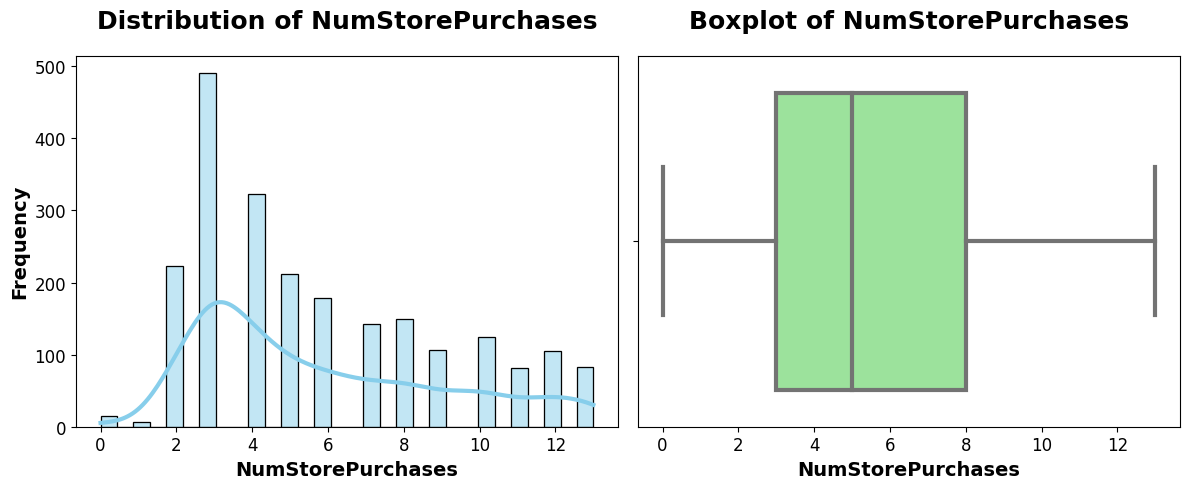

Number of outliers in NumStorePurchases: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


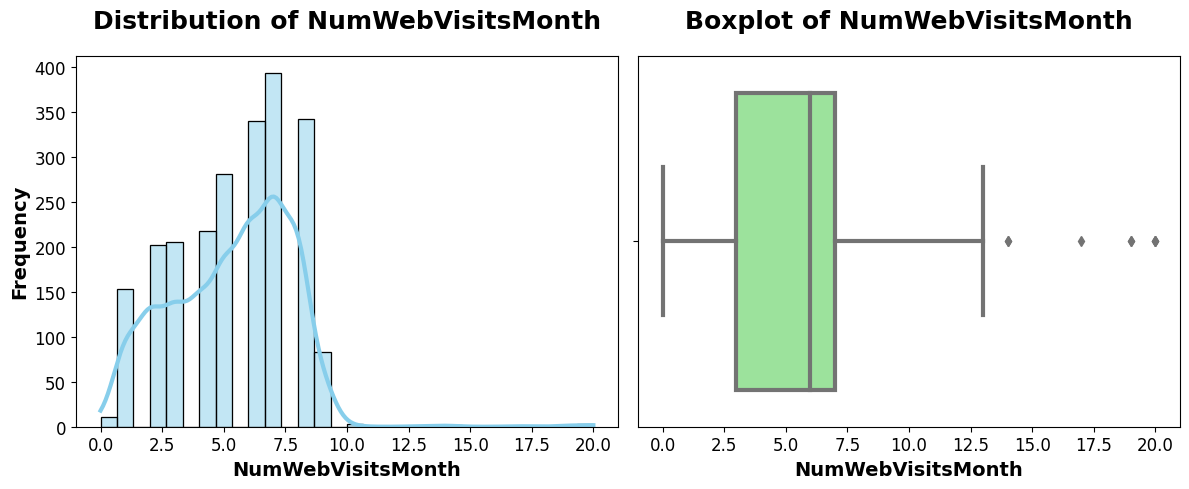

Number of outliers in NumWebVisitsMonth: 8


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


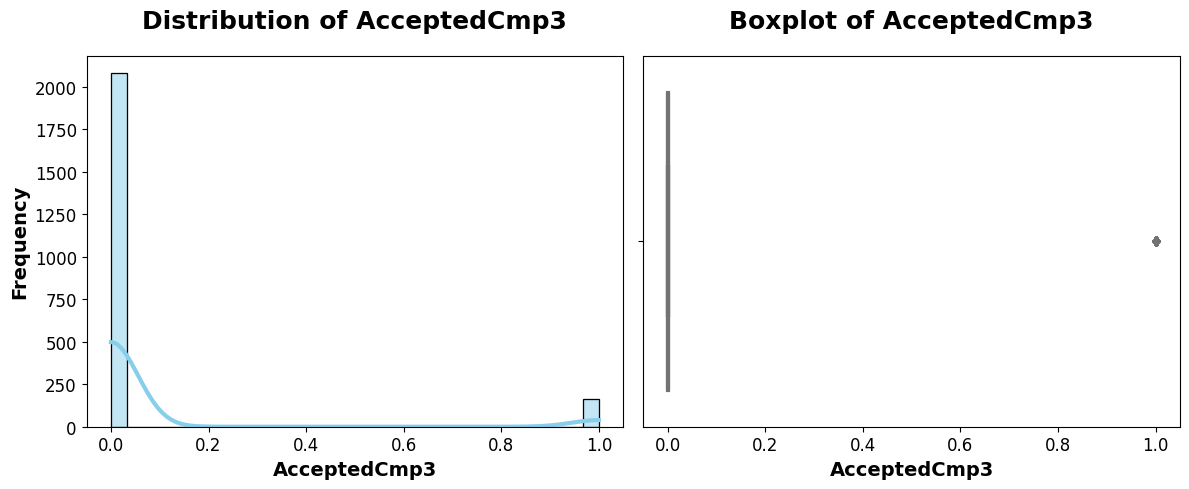

Number of outliers in AcceptedCmp3: 163


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


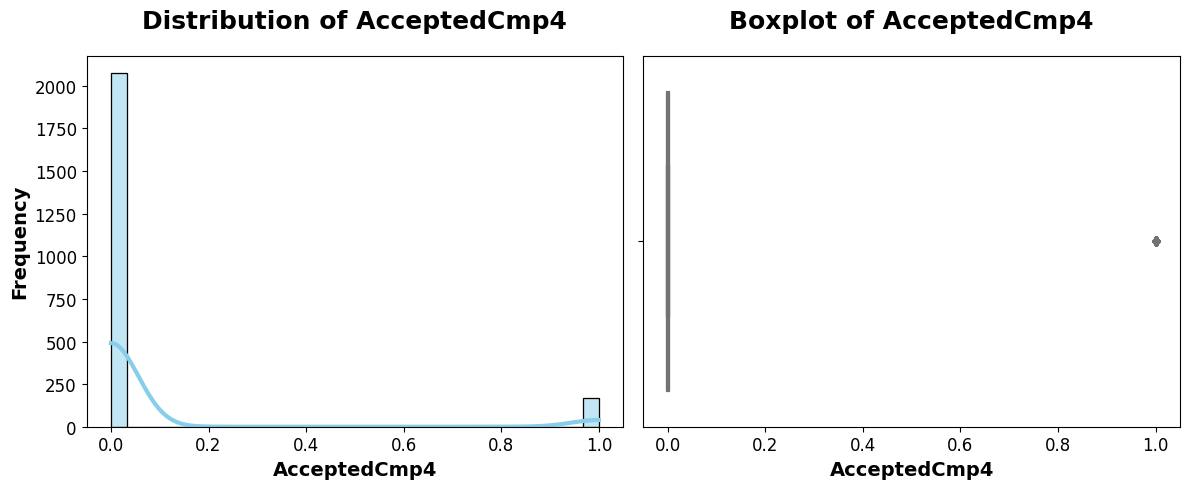

Number of outliers in AcceptedCmp4: 167


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


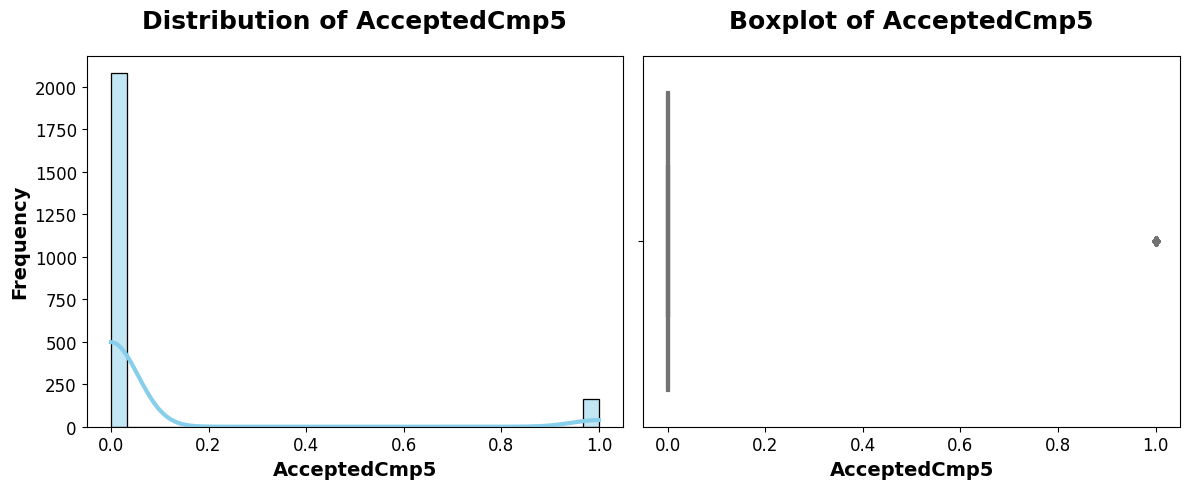

Number of outliers in AcceptedCmp5: 163


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


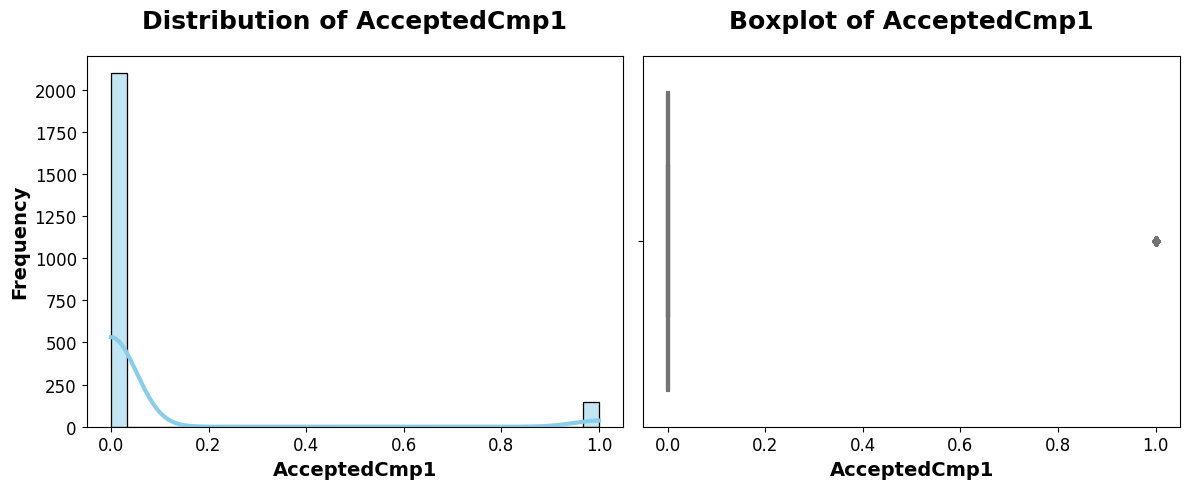

Number of outliers in AcceptedCmp1: 144


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


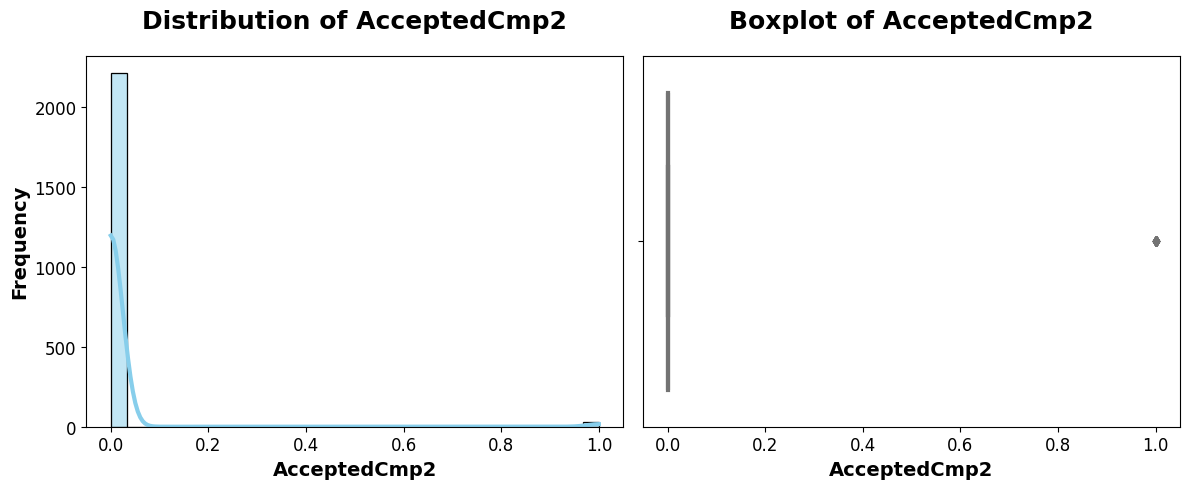

Number of outliers in AcceptedCmp2: 30


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


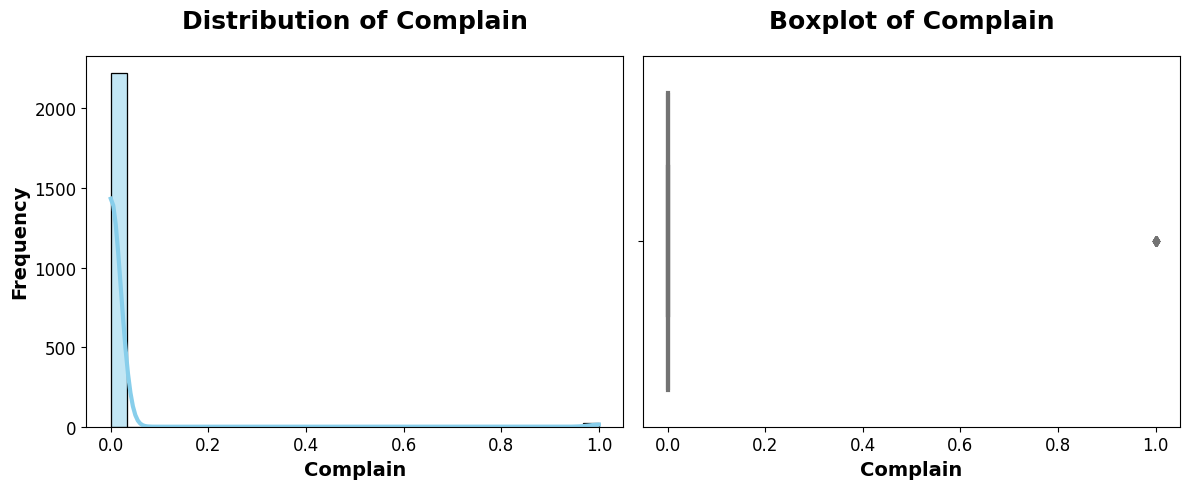

Number of outliers in Complain: 21


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


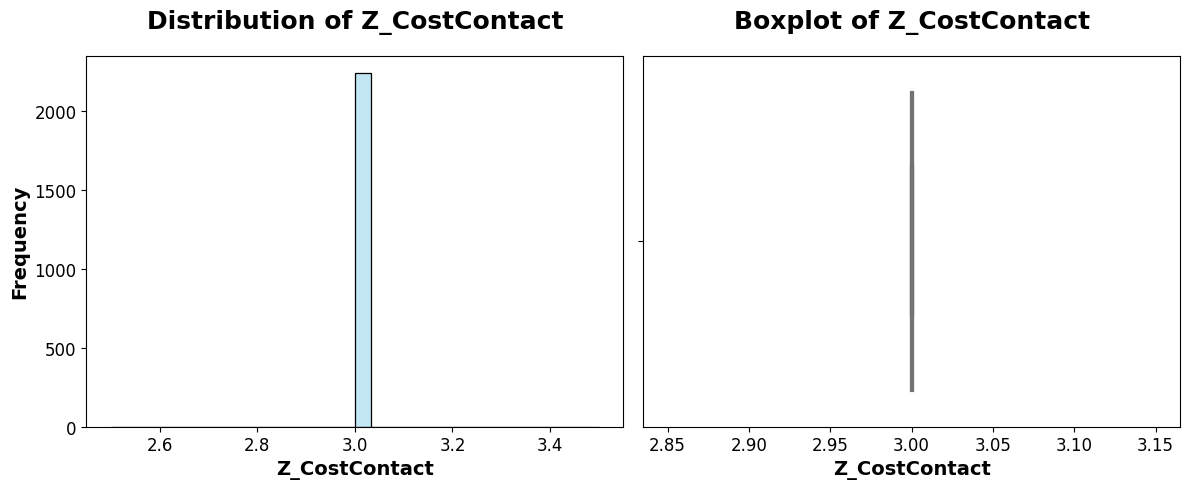

Number of outliers in Z_CostContact: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


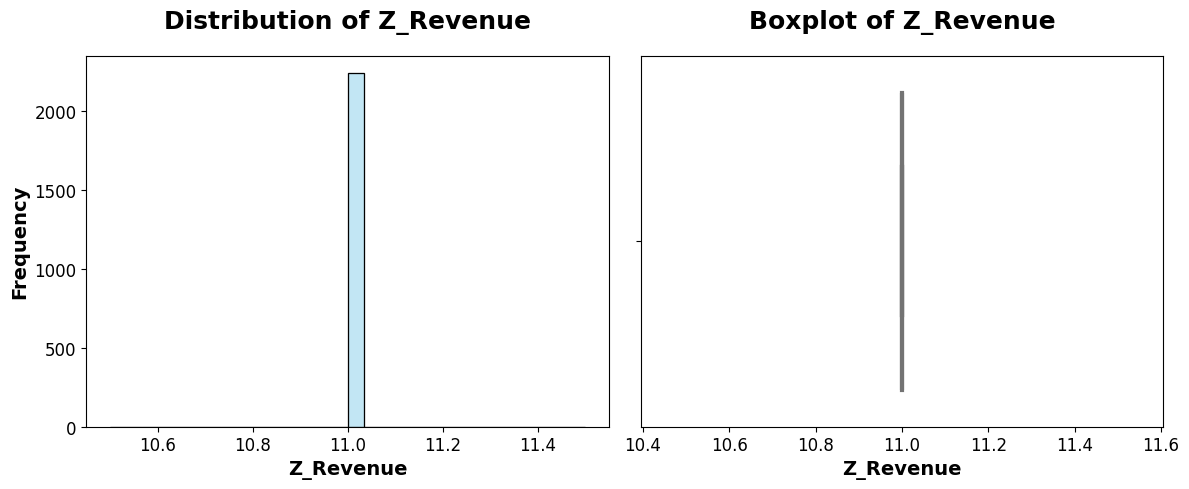

Number of outliers in Z_Revenue: 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


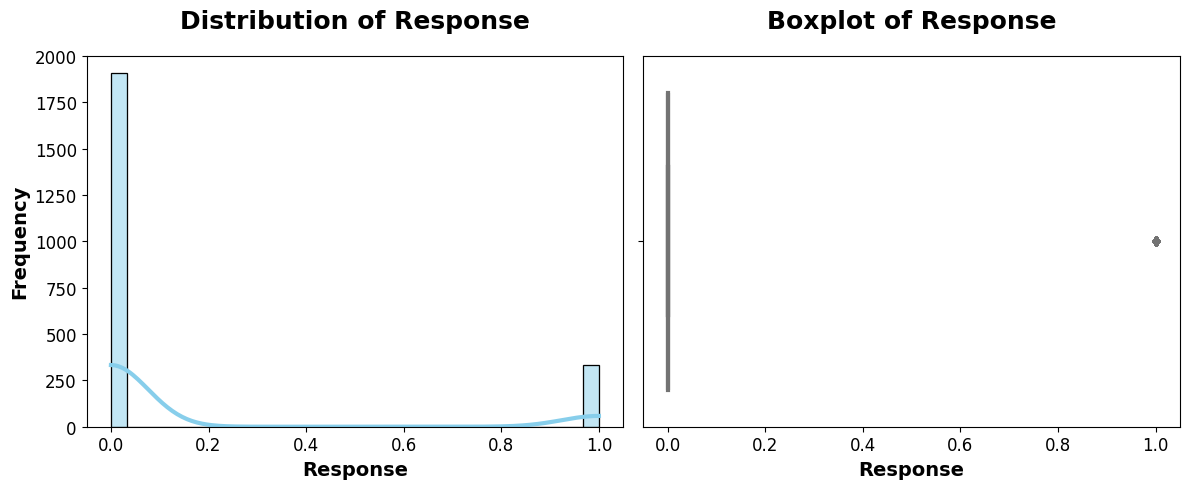

Number of outliers in Response: 334


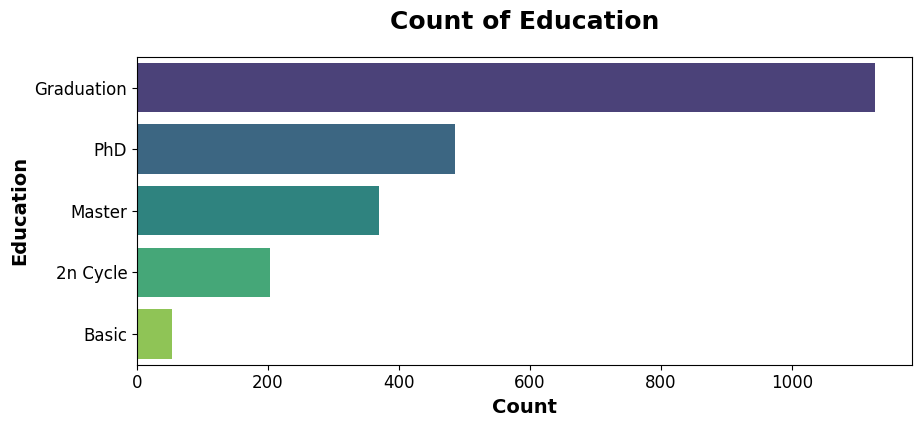

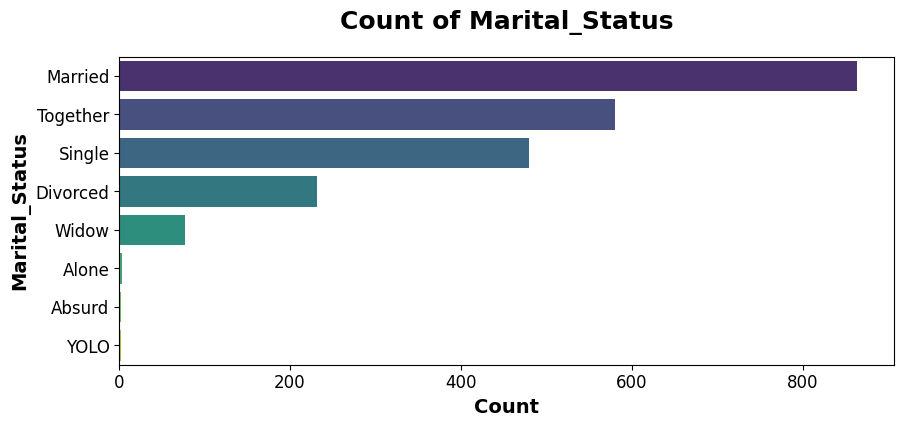

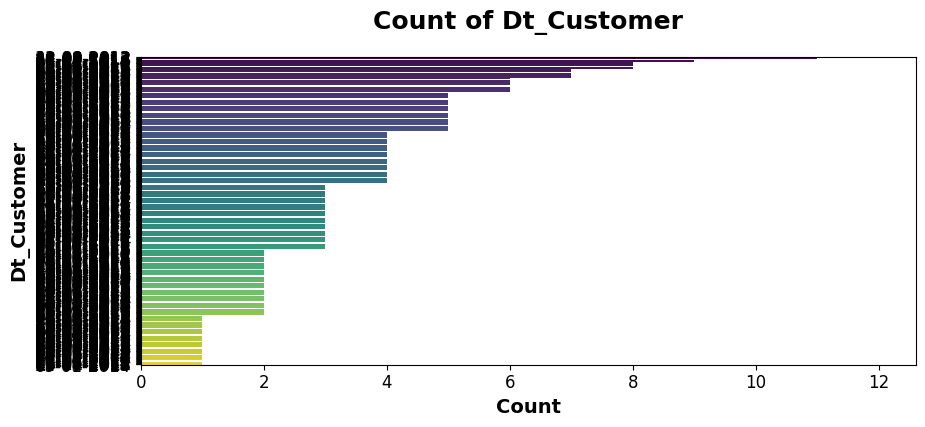

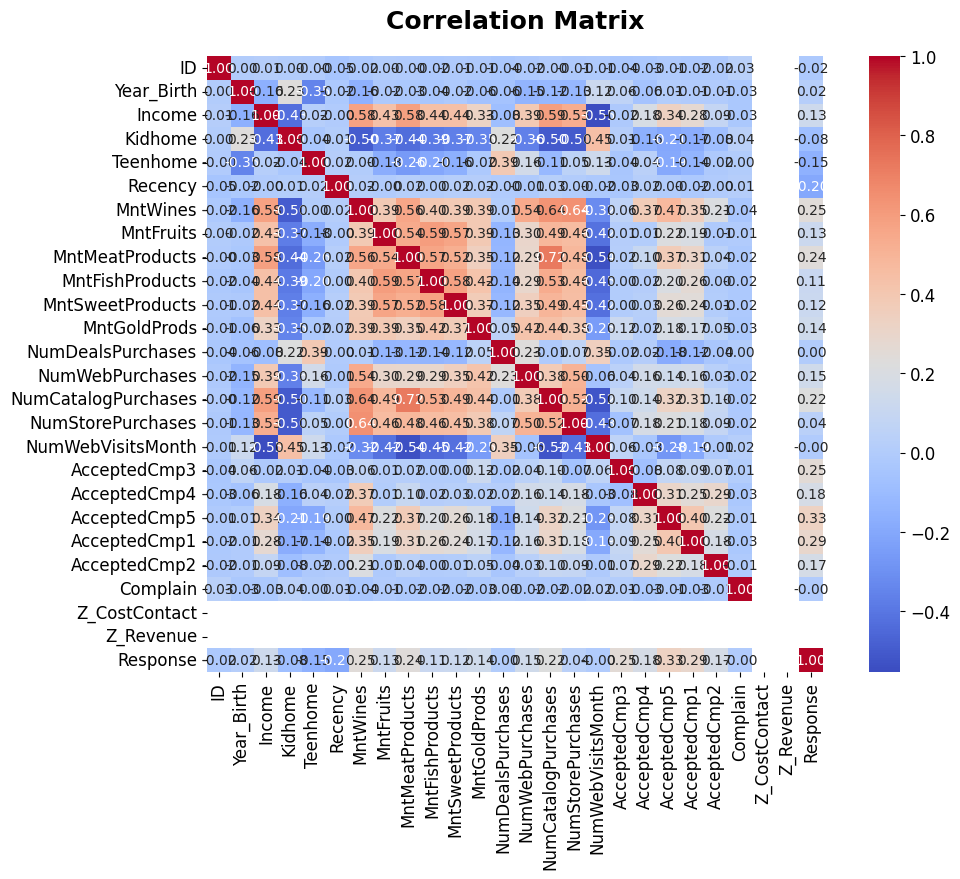

'\nAdditional Analysis:'

Top 10 Most Correlated Feature Pairs:


MntMeatProducts      NumCatalogPurchases    0.72
NumCatalogPurchases  MntMeatProducts        0.72
MntWines             NumStorePurchases      0.64
NumStorePurchases    MntWines               0.64
NumCatalogPurchases  MntWines               0.64
MntWines             NumCatalogPurchases    0.64
MntFruits            MntFishProducts        0.59
MntFishProducts      MntFruits              0.59
Income               NumCatalogPurchases    0.59
NumCatalogPurchases  Income                 0.59
dtype: float64

'\nNumber of Duplicate Rows: 0'

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [7]:
perform_eda(df)

NOTE : 
1. in the dataset Year_birth min is 1893 !!
    
--> For this study, we are going to keep recent data only. 

In [8]:
print(f"Original dataset size: {df.shape[0]} rows")

# Keep only the rows where Year_Birth > 1949
df = df[df['Year_Birth'] > 1949]

# Display the shape of the filtered DataFrame

print(f"Filtered dataset size: {df.shape[0]} rows")

Original dataset size: 2240 rows
Filtered dataset size: 2130 rows


In [9]:
# ==================================================================
# Missing Values
# =================================================================
# Check for missing values
display("\nMissing Values:")
missing_values = df.isnull().sum()
display(missing_values)

# Remove rows with any null values
df = df.dropna()

# Display the new shape of the dataset after dropping nulls
print(f"New dataset shape after removing rows with null values: {df.shape}")

'\nMissing Values:'

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 23
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

New dataset shape after removing rows with null values: (2107, 29)


In [10]:
# ==================================================================
# FEATURE ENGINEERING
# =================================================================
df['Age'] = 2023 - df['Year_Birth']
df['TotalChildren'] = df['Kidhome'] + df['Teenhome']
df['TotalSpending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['TotalAcceptedCampaigns'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Response']


In [11]:
# ==================================================================
# ONE HOT ENCODING FOR CATEGORICAL FEATURES
# =================================================================
from sklearn.preprocessing import LabelEncoder

# Categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Encoding categorical features
for col in cat_cols:
        # apply Label Encoding

        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

print(f"\nLabel Encoding:")
display(df.head())  # Show the DataFrame after encoding



Label Encoding:


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,TotalChildren,TotalSpending,TotalAcceptedCampaigns
0,5524,1957,2,4,58138.0,0,0,80,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,66,0,1617,1
1,2174,1954,2,4,46344.0,1,1,157,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,69,2,27,0
2,4141,1965,2,5,71613.0,0,0,444,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,58,0,776,0
3,6182,1984,2,5,26646.0,1,0,199,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,39,1,53,0
4,5324,1981,4,3,58293.0,1,0,390,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,42,1,422,0
